# AirMSPI Preprocessing
---

This notebook demonstrates AirMSPI [[1]] registration for a cropped isolated cloud. Since clouds moves while views are aquired by AirMSPI push-broom camera, tomography rays do not interesect in 3D. The goal of this notebook is to register the images to a moving reference frame of the cloud center of mass. The cloud processed in this notebook is part of a PODEX [[2]] scene above the north Pacific ocean [[3]]. 


[1]: https://asdc.larc.nasa.gov/project/AIRMSPI    

[2]: https://asdc.larc.nasa.gov/project/AIRMSPI/AirMSPI_PODEX_Ellipsoid-projected_Georegistered_Radiance_Data_5/20130206-date-imagery  

[3]: https://asdc.larc.nasa.gov/documents/airmspi/images/ELLIPSOID/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202754Z_NorthPacificOcean-32N123W_000N_F01_V005.jpg

In [2]:
import os
import numpy as np
import pyshdom
from scipy import optimize
import matplotlib.pylab as plt
import xarray as xr
from collections import OrderedDict
import warnings
import datetime
from tqdm.notebook import tqdm
import pymap3d as pm
import glob

warnings.filterwarnings('ignore')
%matplotlib notebook

In [3]:
"""
Load pre-processed cropped cloud data (scripts/airmspi_crop_data.py)
"""
km = 1e3

def to_km_units(data):
    data.XDim.attrs.update(units='km')
    data.YDim.attrs.update(units='km')
    data['XDim'] = xr.DataArray(data['XDim'] / km, attrs=data['XDim'].attrs)
    data['YDim'] = xr.DataArray(data['YDim'] / km, attrs=data['YDim'].attrs)
    return data

datapath = '../data/airmspi/26-May-2021-18:56:49_Cropped*'
data = xr.open_mfdataset(datapath, group='radiance', combine='nested').sel(band='935nm')

# Update units to kilometers and align to center of grid
data = to_km_units(data)
x0, y0 = data['XDim'].mean(), data['YDim'].mean()
data['XDim'] = data['XDim'] - x0
data['YDim'] = data['YDim'] - y0

In [5]:
"""
Compute image center of mass (COM) rays and put them into a dictionary along with pixel direction and time.

Notes
-----
Raises a warning: .../scipy/ndimage/measurements.py:1406: RuntimeWarning: 
invalid value encountered in true_divide 
"""
radiance_threshold = 5e-3

rays = {}
zeniths = {}
azimuths = {}
for view_angle in tqdm(data.view_angle.data[::-1]):
    image = data.I.sel(view_angle=view_angle)
    comy, comx = pyshdom.preprocessing.get_com_indices(image.load(), thresh=radiance_threshold)
    
    # Azimuth is measured from North and X is pointing East.
    # https://asdc.larc.nasa.gov/documents/airmspi/guide/AirMSPI_Cloud_Droplet_ATBD.20180117.pdf
    zenith = data.View_zenith.sel(view_angle=view_angle).isel(XDim=comx, YDim=comy).values 
    azimuth = 90 - data.View_azimuth.sel(view_angle=view_angle).isel(XDim=comx, YDim=comy).values
    direction = pyshdom.util.spherical_coords_to_vector(zenith, azimuth)
    
    seconds = float(data.isel(XDim=comx, YDim=comy).sel(view_angle=view_angle).Time_in_seconds_from_epoch.values)
    time = data.sel(view_angle=view_angle).time.values + np.timedelta64(datetime.timedelta(seconds=seconds))

    rays[view_angle] = {'x': image['XDim'][comx].values, 
                        'y':image['YDim'][comy].values, 
                        'z': 0.0,
                        'direction': direction, 
                        'time': time}

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


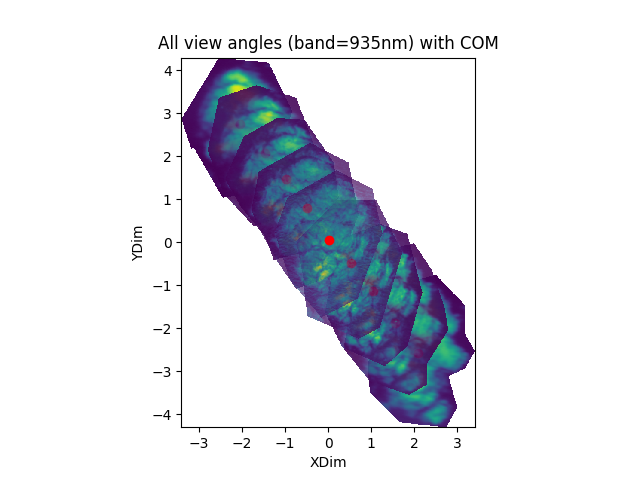

In [6]:
"""
Overlay all view angles and plot center of masses for each image.
"""
alphas = [1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.7]
plt.figure()
for alpha, view_angle in zip(alphas, data.view_angle.data[::-1]):
    image = data.I.sel(view_angle=view_angle)
    image.plot(add_colorbar=False, alpha=alpha)
    plt.scatter(rays[view_angle]['x'], rays[view_angle]['y'], color='red')
plt.title('All view angles (band={}) with COM'.format(str(image.band.data)))
plt.gca().set_aspect('equal')

In [7]:
"""
In the absence of cloud motion, pixel rays originating from the COMs of each image 
should intersect at a common 3D point. Due to cloud motion they dont intesect and there is a need to register
the coordinate system to a moving reference frame. This cell computes the constant velocity and 3D COM point.

Notes
-----
To limit the solution space there is a bound on acceptable Z velocity and X velocity (along flight direction).
"""
ref_view = '000N'
max_v = 20.0 / 3600 # [km / second]
com3d, velocity = pyshdom.preprocessing.find_intersection_line(
    rays, ref_view, z_bounds=(0.5,5.0), vx_bounds=(-max_v, max_v), vz_bounds=(-max_v, max_v)
)
print('Cloud altitude: {:2.2f}[km] ; Velocity: {:2.2f}[km/h]'.format(com3d[2], np.linalg.norm(velocity) * 3600))

Cloud altitude: 1.44[km] ; Velocity: 41.48[km/h]


<IPython.core.display.Javascript object>


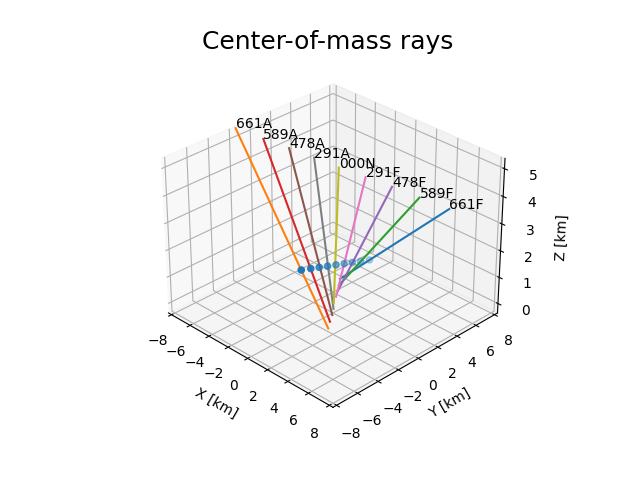

In [14]:
"""
Plots the rays originating from the COM of each image _BEFORE_ registration. 
The scatter points show a constant cloud velocity computed by the optimization (previous cell).
"""
toa = 5.0
xylim = 8.0

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.set_title('Center-of-mass rays', fontsize=18)
for view_angle, ray in rays.items():
    direction = ray['direction']
    t = toa / direction[2]
    ax.plot([ray['x'], ray['x'] + direction[0] * t], [ray['y'], ray['y'] + direction[1]*t], [0, direction[2]*t])
    ax.text(ray['x'] + direction[0]*t, ray['y'] + direction[1]*t, direction[2]*t, view_angle)
ax.set_ylim([-xylim, xylim])
ax.set_xlim([-xylim, xylim])

points = []
reference_view = '000N'
for ray in rays.values():
    dt = (ray['time'] - rays[reference_view]['time']) / np.timedelta64(1, 's')
    point = com3d + dt * velocity
    points.append(point)
ax.scatter(*list(zip(*points)))
ax.azim = -45

<IPython.core.display.Javascript object>


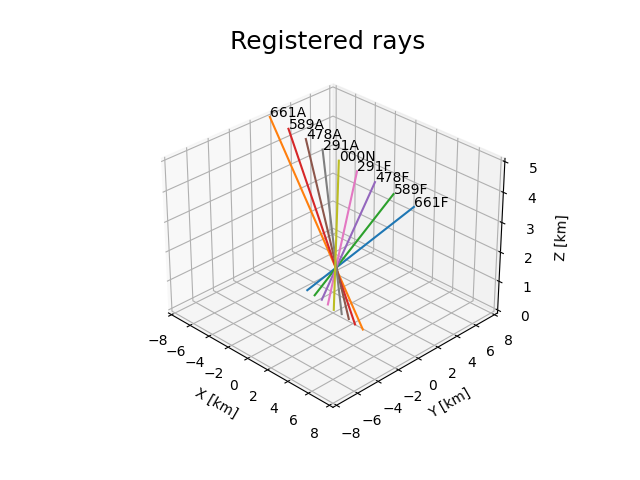

In [15]:
"""
Plots the rays originating from the COM of each image _AFTER_ registration. 
There rays now are 'close' to intersecting.
"""
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.set_title('Registered rays', fontsize=18)

for view_angle, ray in rays.items():
    dt = np.timedelta64(ray['time'] - rays[ref_view]['time'], 's').astype('d')
    comx = ray['x'] - dt * velocity[0]
    comy = ray['y'] - dt * velocity[1]
    comz = ray['z']
    direction = ray['direction']
    t = toa/direction[2]
    ax.plot([comx, comx + direction[0] * t], [comy, comy + direction[1]*t], [comz, comz + direction[2]*t])
    ax.text(comx + direction[0]*t, comy + direction[1]*t, comz + direction[2]*t, view_angle)
    
ax.azim = -45
ax.set_ylim([-xylim, xylim]);
ax.set_xlim([-xylim, xylim]);

In [10]:
"""
Register AirMSPI data to the moving reference frame and save to files
"""
datapath = '../data/airmspi/26-May-2021-18:56:49_Cropped*'
files = glob.glob(datapath)
for file in tqdm(files):
    rad_data = xr.open_dataset(file, group='radiance')
    pol_data = xr.open_dataset(file, group='polarization')
    rad_data = to_km_units(rad_data)
    pol_data = to_km_units(pol_data)
    
    view_angle = rad_data.view_angle.values[0]
    dt = np.timedelta64(rays[view_angle]['time'] - rays[ref_view]['time'], 's').astype('d')
    rad_data['XDim'] = rad_data['XDim'] - dt * velocity[0] - x0
    rad_data['YDim'] = rad_data['YDim'] - dt * velocity[1] - y0
    pol_data['XDim'] = pol_data['XDim'] - dt * velocity[0] - x0
    pol_data['YDim'] = pol_data['YDim'] - dt * velocity[1] - y0
    
    outpath = file.replace('Cropped', 'Preprocessed')
    rad_data.to_netcdf(outpath, group='radiance')
    pol_data.to_netcdf(outpath, group='polarization', mode='a')

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


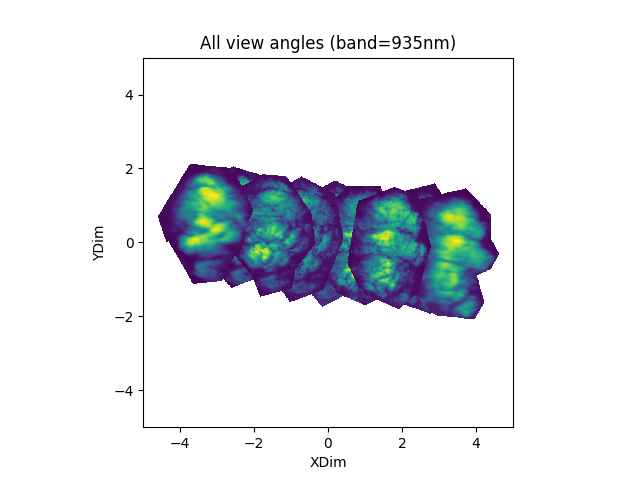

In [13]:
"""
Plot aligned dataset images.
"""
files = glob.glob('../data/airmspi/26-May-2021-18:56:49_Preprocessed*')
plt.figure()
for file in files:
    image = xr.load_dataset(file, group='radiance').sel(band='935nm').I.squeeze()
    image.plot(add_colorbar=False)
plt.title('All view angles (band={})'.format(str(image.band.data)))
plt.gca().set_aspect('equal')
plt.xlim([-5,5]);
plt.ylim([-5,5]);